# Setup

In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")

In [2]:
from nnsight import LanguageModel, CONFIG
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch as th
import torch  # for those who are afraid of th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from pathlib import Path
from time import time
import itertools
from dataclasses import dataclass
from warnings import warn

th.set_grad_enabled(False)
import os

# os.environ["HF_TOKEN"] = "HF_TOKEN"
# CONFIG.set_default_api_key("<nnsight key for remote execution>")
dlabscratch = Path("/dlabscratch1/dlabscratch1/")
if not dlabscratch.exists():
    dlabscratch = dlabscratch.parent


@dataclass
class Config:
    remote: bool = False


config = Config()

# Utils

In [3]:
from IPython.display import Markdown, display


@dataclass
class Config:
    remote: bool = False
    max_batch_size: int = 1


config = Config()


def displaymd(string):
    display(
        Markdown(string.replace("<s>", "<‎s>"))
    )  # Little hack to prevent <s> from being interpreted as the html tag for strikethrough

In [4]:
from utils import plot_topk_tokens as plot_topk


def display_generations_md(nn_model, prompts, gen_strings: dict, replace_str=None):
    if isinstance(prompts, str):
        prompts = [prompts]
    md_strings = []

    def preprocess(s):
        if replace_str is not None:
            return s.replace(replace_str, "[[REPLACED]]")
        return s

    for i, prompt in enumerate(prompts):
        prompt = prompt.replace("\n", "\n\n")
        md_strings.append(f"**Prompt:** {prompt}")
        for k, v in gen_strings.items():
            gen = nn_model.tokenizer.decode(v[i])
            md_strings.append(
                f"- **Layer {k}:**<br>\n" + f"```\n{preprocess(gen)}\n```"
            )
        md_strings.append("\n")
    out = "\n".join(md_strings)
    displaymd(out)


def generations_to_table(nn_model, prompts, gen_strings: dict, replace_str=None):
    if isinstance(prompts, str):
        prompts = [prompts]
    df = pd.DataFrame({"Prompt": prompts})

    def preprocess(s):
        if replace_str is not None:
            return s.replace(replace_str, "[[REPLACED]]")
        return s

    dic = {
        f"Layer {k}": [preprocess(nn_model.tokenizer.decode(v)) for v in gen_strings[k]]
        for k in gen_strings
    }
    dflayer = pd.DataFrame(dic)
    df = pd.concat([df, dflayer], axis=1)
    df.style.hide(axis="index")
    return df


def display_generations_table(nn_model, prompts, gen_strings: dict, replace_str=None):
    df = generations_to_table(nn_model, prompts, gen_strings, replace_str)
    # fmt: off
    with pd.option_context(
        "display.max_colwidth", None,
        "display.max_columns", None,
        "display.max_rows", None,
    ):
        display(df)
    # fmt: on

# Patchscope & logit lens

In [5]:
from exp_tools import logit_lens_llama as logit_lens

In [6]:
from exp_tools import patchscope_generate_llama as patchscope_generate
from exp_tools import patchscope_lens
from exp_tools import TargetPrompt as TargetPrompt

# Prompt Utils

In [7]:
def identity_prompt(
    nn_model=None, words=None, rel=" -> ", sep="\n", placeholder="?"
) -> TargetPrompt:
    """
    Prompt used in the patchscopes paper to predict the next token.
    https://github.com/PAIR-code/interpretability/blob/master/patchscopes/code/next_token_prediction.ipynb
    """
    if words is None:
        words = ["cat", "1135", "hello"]
    assert nn_model is None or (
        len(nn_model.tokenizer.tokenize(placeholder)) == 1
    ), "Using a placeholder that is not a single token sounds like a bad idea"
    prompt = sep.join([w + rel + w for w in words]) + sep + placeholder
    index_to_patch = -1
    return TargetPrompt(prompt, index_to_patch)


def description_prompt(placeholder="?"):
    return TargetPrompt(
        f"""Jensen Huang is the CEO of NVIDIA, a technology company
New York City is the largest city in the United States
Johnny Depp is a famous actor known for his role in Pirates of the Caribbean
Google is a technology company known for its search engine
Ariana Grande is a famous singer from the United States
Sam Altman is the CEO of OpenAI, a research lab focused on artificial intelligence
The Eiffel Tower is a famous landmark in Paris, France
C++ is a programming language known for its speed and performance
A spoon is a utensil used for eating food
{placeholder}""",
        -1,
    )


example = identity_prompt()
displaymd(
    f"**Prompt:**\n```\n{example.prompt}\n```\n**Index to patch:** {example.index_to_patch}"
)

**Prompt:**
```
cat -> cat
1135 -> 1135
hello -> hello
?
```
**Index to patch:** -1

# Playground

In [8]:
es_de_prompt = """Español: "rojo" - Deutsch: "rot"
Español: "mano" - Deutsch: "Hand"
Español: "grupo" - Deutsch: "Gruppe"
Español: "estrella" - Deutsch: "Stern"
Español: "puente" - Deutsch: "Brücke"
Español: "gato" - Deutsch: \""""
fr_en_prompt = """Français: "rouge" - English: "red"
Français: "main" - English: "hand"
Français: "groupe" - English: "group"
Français: "étoile" - English: "star"
Français: "pont" - English: "bridge"
Français: "chat" - English: \""""
es_fr_prompt = """Español: "rojo" - Français: "rouge"
Español: "mano" - Français: "main"
Español: "grupo" - Français: "groupe"
Español: "estrella" - Français: "étoile"
Español: "puente" - Français: "pont"
Español: "gato" - Français: \""""
de_zh_prompt = """Deutsch: "Fluss" - 中文: "河"
Deutsch: "Auge" - 中文: "眼睛"
Deutsch: "Meer" - 中文: "海"
Deutsch: "Person" - 中文: "现代人"
Deutsch: "Mutter" - 中文: "母親"
Deutsch: "Buch" - 中文: \""""
de_zh_prompt2 = """Deutsch: "Fluss" - 中文: "河"
Deutsch: "Auge" - 中文: "眼睛"
Deutsch: "Meer" - 中文: "海"
Deutsch: "Person" - 中文: "现代人"
Deutsch: "Buch" - 中文: "書"
Deutsch: "Mutter" - 中文: \""""

In [9]:
# llama_like = dlabscratch / "public/llm_weights/llama2_hf/Llama-2-7b-hf"
# llama_like = "croissantllm/croissantllmbase"; config.remote = False
# llama_like = dlabscratch / "public/llm_weights/llama3_hf/Meta-Llama-3-8B"
llama_like = "/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf"
nn_model = LanguageModel(llama_like, torch_dtype=th.float16, device_map="auto")

## Patchscoping

In [10]:
prompt = 'Español: "rojo" - Deutsch: "rot"\nEspañol: "mano" - Deutsch: "Hand"\nEspañol: "grupo" - Deutsch: "Gruppe"\nEspañol: "estrella" - Deutsch: "Stern"\nEspañol: "puente" - Deutsch: "Brücke"\nEspañol: "perra" - Deutsch: "'

In [11]:
prompt = 'Español: "rojo" - Deutsch: "rot"\nEspañol: "mano" - Deutsch: "Hand"\nEspañol: "grupo" - Deutsch: "Gruppe"\nEspañol: "estrella" - Deutsch: "Stern"\nEspañol: "puente" - Deutsch: "Brücke"\nEspañol: "perra" - Deutsch: "'

In [12]:
fr_en_prompt

'Français: "rouge" - English: "red"\nFrançais: "main" - English: "hand"\nFrançais: "groupe" - English: "group"\nFrançais: "étoile" - English: "star"\nFrançais: "pont" - English: "bridge"\nFrançais: "chat" - English: "'

TargetPrompt(prompt='Español: "rojo" - Deutsch: "rot"\nEspañol: "mano" - Deutsch: "Hand"\nEspañol: "grupo" - Deutsch: "Gruppe"\nEspañol: "estrella" - Deutsch: "Stern"\nEspañol: "puente" - Deutsch: "Brücke"\nEspañol: "perra" - Deutsch: "', index_to_patch=-1)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


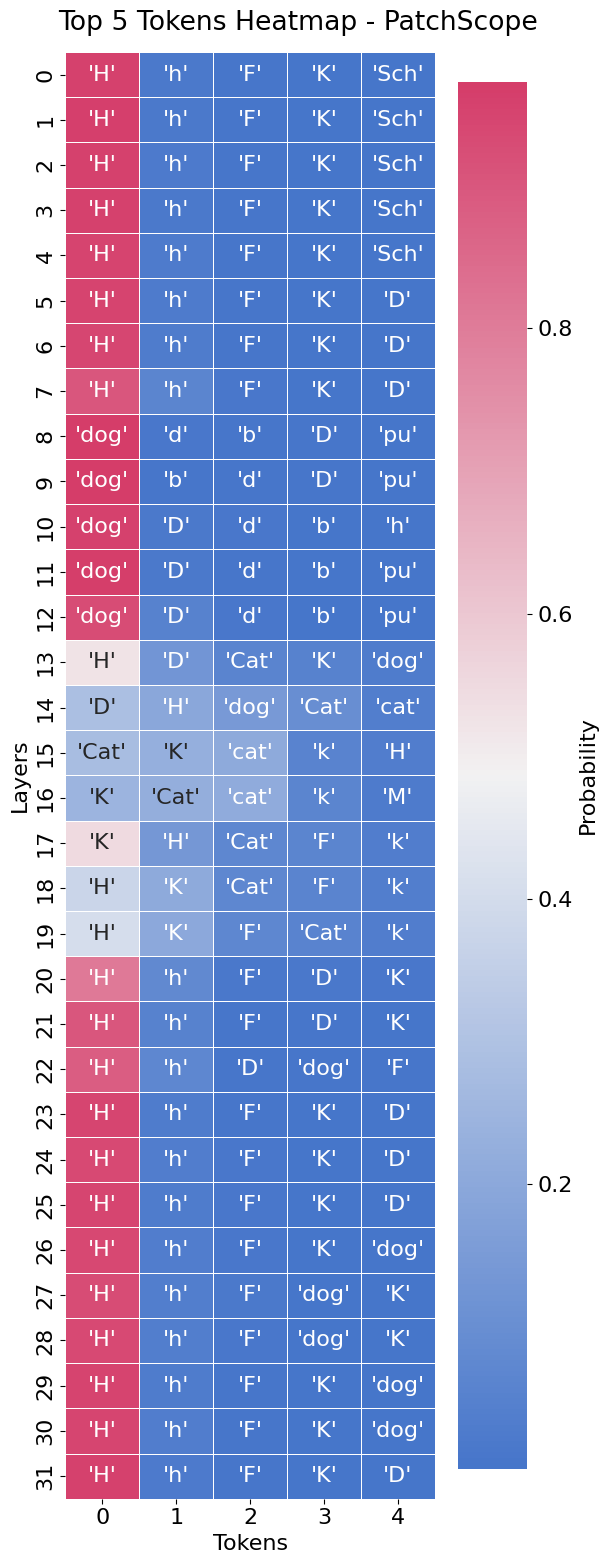

In [13]:
from exp_tools import attn_patchscope_lens_llama
patch_prompt = TargetPrompt(prompt, -1)
print(patch_prompt)
patch_probs = attn_patchscope_lens_llama(nn_model, fr_en_prompt, patch_prompt, remote=False)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope")

In [14]:
de_zh_prompt

'Deutsch: "Fluss" - 中文: "河"\nDeutsch: "Auge" - 中文: "眼睛"\nDeutsch: "Meer" - 中文: "海"\nDeutsch: "Person" - 中文: "现代人"\nDeutsch: "Mutter" - 中文: "母親"\nDeutsch: "Buch" - 中文: "'

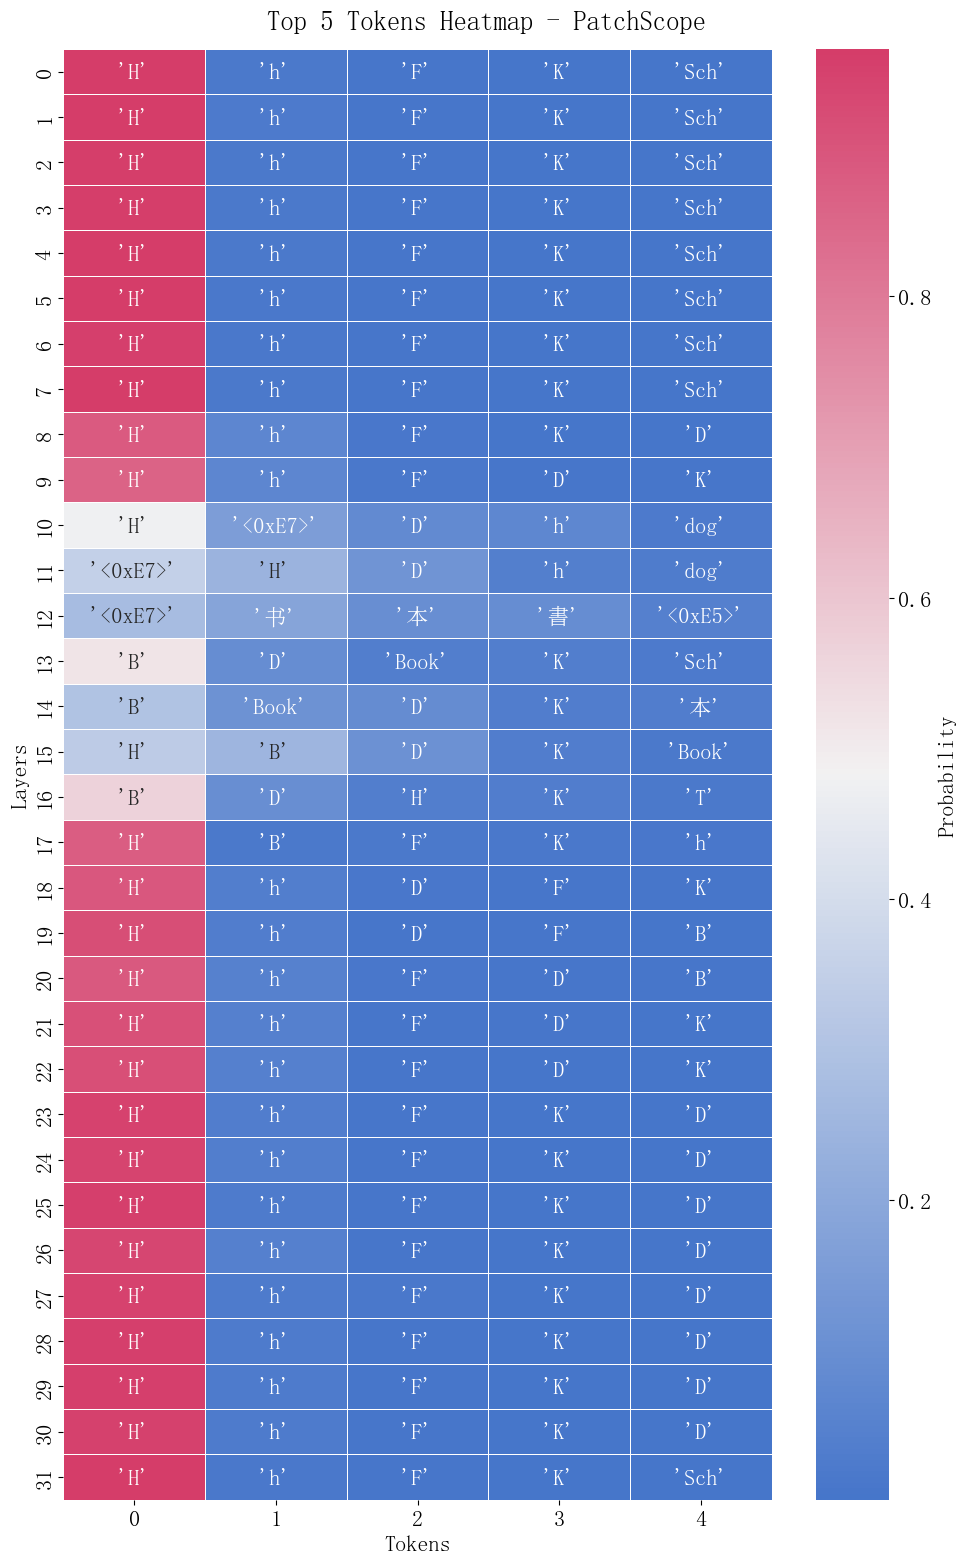

In [15]:
patch_probs = attn_patchscope_lens_llama(nn_model, de_zh_prompt, patch_prompt, remote=False)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope")